In [1]:
abstract type AbstractJumpAggregator end
abstract type AbstractJump end
abstract type AbstractSSAJumpAggregator <: AbstractJumpAggregator end
mutable struct DirectJumpAggregation{T,S,F1,F2,RNG} <: AbstractSSAJumpAggregator
  next_jump::Int
  prev_jump::Int
  next_jump_time::T
  end_time::T
  cur_rates::Vector{T}
  sum_rate::T
  ma_jumps::S
  rates::F1
  affects!::F2
  save_positions::Tuple{Bool,Bool}
  rng::RNG
end
DirectJumpAggregation(nj::Int, njt::T, et::T, crs::Vector{T}, sr::T, maj::S, rs::F1, affs!::F2, sps::Tuple{Bool,Bool}, rng::RNG; kwargs...) where {T,S,F1,F2,RNG} =
  DirectJumpAggregation{T,S,F1,F2,RNG}(nj, nj, njt, et, crs, sr, maj, rs, affs!, sps, rng)

DirectJumpAggregation

In [2]:
abstract type AbstractAggregatorAlgorithm end
struct Direct <: AbstractAggregatorAlgorithm end

In [3]:
# creating the JumpAggregation structure (tuple-based constant jumps)
function aggregate(aggregator::Direct, u, p, t, end_time, constant_jumps,
    ma_jumps, save_positions, rng; kwargs...)

# handle constant jumps using tuples
rates, affects! = get_jump_info_tuples(constant_jumps)

build_jump_aggregation(DirectJumpAggregation, u, p, t, end_time, ma_jumps,
          rates, affects!, save_positions, rng; kwargs...)
end

aggregate (generic function with 1 method)

In [4]:
function get_jump_info_tuples(constant_jumps)
    if (constant_jumps !== nothing) && !isempty(constant_jumps)
      rates    = ((c.rate for c in constant_jumps)...,)
      affects! = ((c.affect! for c in constant_jumps)...,)
    else
      rates    = ()
      affects! = ()
    end
  
    rates, affects!
  end

get_jump_info_tuples (generic function with 1 method)

In [5]:
function build_jump_aggregation(jump_agg_type, u, p, t, end_time, ma_jumps, rates,
    affects!, save_positions, rng; kwargs...)

# mass action jumps
majumps = ma_jumps
if majumps === nothing
majumps = MassActionJump(Vector{typeof(t)}(),
 Vector{Vector{Pair{Int,eltype(u)}}}(),
 Vector{Vector{Pair{Int,eltype(u)}}}())
end

# current jump rates, allows mass action rates and constant jumps
cur_rates = Vector{typeof(t)}(undef, get_num_majumps(majumps) + length(rates))

sum_rate = zero(typeof(t))
next_jump = 0
next_jump_time = typemax(typeof(t))
jump_agg_type(next_jump, next_jump_time, end_time, cur_rates, sum_rate,
majumps, rates, affects!, save_positions, rng; kwargs...)
end

build_jump_aggregation (generic function with 1 method)

## where `get_num_majumps` is defined by:

Here invoque type `MassActionJump`  so have to define it as follows

# Define ConstantRateJump and MassActionJump

In [6]:
#TODO Simplify the code pmapper maybe
struct MassActionJump{T,S,U,V} <: AbstractJump
    scaled_rates::T
    reactant_stoch::S
    net_stoch::U
    param_mapper::V
  
    function MassActionJump{T,S,U,V}(rates::T, rs_in::S, ns::U, pmapper::V, scale_rates::Bool, useiszero::Bool, nocopy::Bool) where {T <: AbstractVector, S, U, V}
      sr  = nocopy ? rates : copy(rates)
      rs = nocopy ? rs_in : copy(rs_in)
      for i in eachindex(rs)
        if useiszero && (length(rs[i]) == 1) && iszero(rs[i][1][1])
          rs[i] = typeof(rs[i])()
        end
      end
  
      if scale_rates && !isempty(sr)
        scalerates!(sr, rs)
      end
      new(sr, rs, ns, pmapper)
    end
    function MassActionJump{Nothing,Vector{S},Vector{U},V}(::Nothing, rs_in::Vector{S}, ns::Vector{U}, pmapper::V, scale_rates::Bool, useiszero::Bool, nocopy::Bool) where {S<:AbstractVector, U<:AbstractVector, V}
      rs = nocopy ? rs_in : copy(rs_in)
      for i in eachindex(rs)
        if useiszero && (length(rs[i]) == 1) && iszero(rs[i][1][1])
          rs[i] = typeof(rs[i])()
        end
      end
      new(nothing, rs, ns, pmapper)
    end
    function MassActionJump{T,S,U,V}(rate::T, rs_in::S, ns::U, pmapper::V, scale_rates::Bool, useiszero::Bool, nocopy::Bool) where {T <: Number, S, U, V}
      rs = rs_in
      if useiszero && (length(rs) == 1) && iszero(rs[1][1])
        rs = typeof(rs)()
      end
      sr = scale_rates ? scalerate(rate, rs) : rate
      new(sr, rs, ns, pmapper)
    end
    function MassActionJump{Nothing,S,U,V}(::Nothing, rs_in::S, ns::U, pmapper::V, scale_rates::Bool, useiszero::Bool, nocopy::Bool) where {S, U, V}
      rs = rs_in
      if useiszero && (length(rs) == 1) && iszero(rs[1][1])
        rs = typeof(rs)()
      end
      new(nothing, rs, ns, pmapper)
    end
  
end
MassActionJump(usr::T, rs::S, ns::U, pmapper::V; scale_rates = true, useiszero = true, nocopy=false) where {T,S,U,V} = MassActionJump{T,S,U,V}(usr, rs, ns, pmapper, scale_rates, useiszero, nocopy)

MassActionJump(usr::T, rs, ns; scale_rates = true, useiszero = true, nocopy=false) where {T <: AbstractVector,S,U} = MassActionJump(usr, rs, ns, nothing; scale_rates=scale_rates, useiszero=useiszero, nocopy=nocopy)

MassActionJump(usr::T, rs, ns; scale_rates = true, useiszero = true, nocopy=false) where {T <: Number,S,U} = MassActionJump(usr, rs, ns, nothing; scale_rates=scale_rates, useiszero=useiszero, nocopy=nocopy)

# with parameter indices or mapping, multiple jump case
function MassActionJump(rs, ns; param_idxs=nothing, param_mapper=nothing, scale_rates = true, useiszero = true, nocopy=false)
  if param_mapper === nothing 
    (param_idxs === nothing) && error("If no parameter indices are given via param_idxs, an explicit parameter mapping must be passed in via param_mapper.")
    pmapper = MassActionJumpParamMapper(param_idxs)
  else
    (param_idxs !== nothing) && error("Only one of param_idxs and param_mapper should be passed.")
    pmapper = param_mapper
  end
                      
  MassActionJump(nothing, nocopy ? rs : copy(rs), ns, pmapper; scale_rates=scale_rates, 
                 useiszero=useiszero, nocopy=true)
end

MassActionJump

In [7]:
@inline get_num_majumps(maj::MassActionJump) = length(maj.scaled_rates)
@inline get_num_majumps(maj::Nothing) = 0

get_num_majumps (generic function with 2 methods)

In [8]:
struct ConstantRateJump{F1,F2} <: AbstractJump
    rate::F1
    affect!::F2
end  

In [9]:
function scalerates!(unscaled_rates::AbstractVector{U}, stochmat::AbstractVector{V}) where {U,S,T,W <: Pair{S,T}, V <: AbstractVector{W}}
    @inbounds for i in eachindex(unscaled_rates)
        coef = one(T)
        @inbounds for specstoch in stochmat[i]
            coef *= factorial(specstoch[2])
        end
        unscaled_rates[i] /= coef
    end
    nothing
end

function scalerate(unscaled_rate::U, stochmat::AbstractVector{Pair{S,T}}) where {U <: Number, S, T}
    coef = one(T)
    @inbounds for specstoch in stochmat
        coef *= factorial(specstoch[2])
    end
    unscaled_rate /= coef
end

scalerate (generic function with 1 method)

## An example of MassActionJump

In [10]:
rates1 = [0.1/1000.0]
reactant_stoich1 = [[1=>1,2=>1]]
net_stoich1 = [[1=>-1,2=>1]]
jump1 = MassActionJump(rates1, reactant_stoich1, net_stoich1; scale_rates = false)

MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing)

## An example of ConstantRateJump

In [11]:
rate2 = (u,p,t) -> 0.01u[2]
affect! = function (integrator)
  integrator.u[2] -= 1
  integrator.u[3] += 1
end
jump2 = ConstantRateJump(rate2,affect!)

ConstantRateJump{var"#14#15", var"#16#17"}(var"#14#15"(), var"#16#17"())

# Next we want to build aggregator

In [12]:
using SciMLBase, Random
u0 = [999.,1.,0.]
p = SciMLBase.NullParameters()
t0 = 0.0 # initial time
end_time  = 200.
constant_jumps = jump2 
ma_jumps = jump1
save_positions = (false,false)
rng = Random.seed!(1234)

MersenneTwister(1234)

In [13]:
struct JumpSet{T1,T2,T3,T4} <: AbstractJump
    variable_jumps::T1
    constant_jumps::T2
    regular_jump::T3
    massaction_jump::T4
end

In [14]:
jumpset=JumpSet((),(constant_jumps,),nothing,ma_jumps)

JumpSet{Tuple{}, Tuple{ConstantRateJump{var"#14#15", var"#16#17"}}, Nothing, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}}((), (ConstantRateJump{var"#14#15", var"#16#17"}(var"#14#15"(), var"#16#17"()),), nothing, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing))

In [15]:
jumpset.constant_jumps

(ConstantRateJump{var"#14#15", var"#16#17"}(var"#14#15"(), var"#16#17"()),)

In [16]:
dja = aggregate(Direct(),u0,p,t0,end_time,jumpset.constant_jumps, jumpset.massaction_jump, save_positions, rng)

DirectJumpAggregation{Float64, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}, Tuple{var"#14#15"}, Tuple{var"#16#17"}, MersenneTwister}(0, 0, Inf, 200.0, [1.390671161567e-309, 2.121995791e-314], 0.0, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing), (var"#14#15"(),), (var"#16#17"(),), (false, false), MersenneTwister(1234))

## So if we look at the aggregator, the issue is that the next_jump_time = Inf, this is normall because we haven't initialize the prob, in order to do it, one needs to define the `JumpProblem`. Maybe we can skip the defining the DEProblem, because it will have a lot of dependencies. So one idea is to just update `aggregator` for the first time.

In [17]:
"""
fill_rates_and_sum!(p::AbstractSSAJumpAggregator, u, params, t)

Reevaluate all rates and their sum.
"""
function fill_rates_and_sum!(p::AbstractSSAJumpAggregator, u, params, t)
    sum_rate = zero(typeof(p.sum_rate))

    # mass action jumps
    majumps   = p.ma_jumps
    cur_rates = p.cur_rates
    @inbounds for i in 1:get_num_majumps(majumps)
        cur_rates[i] = evalrxrate(u, i, majumps)
        sum_rate    += cur_rates[i]
    end

    # constant rates
    rates = p.rates
    idx   = get_num_majumps(majumps) + 1
    @inbounds for rate in rates
        cur_rates[idx] = rate(u, params, t)
        sum_rate += cur_rates[idx]
        idx += 1
    end

    p.sum_rate = sum_rate
    nothing
end
@inline @fastmath function evalrxrate(speciesvec::AbstractVector{T}, rxidx::S, majump::MassActionJump{U,V,W,X})::R where {T,S,R,U <: AbstractVector{R},V,W,X}
    val = one(T)
    @inbounds for specstoch in majump.reactant_stoch[rxidx]
        specpop = speciesvec[specstoch[1]]
        val    *= specpop
        @inbounds for k = 2:specstoch[2]
            specpop -= one(specpop)
            val     *= specpop
        end
    end

    @inbounds return val * majump.scaled_rates[rxidx]
end

evalrxrate (generic function with 1 method)

## update the rates and sum of rates

In [18]:
fill_rates_and_sum!(dja, u0, p, t0)

In [19]:
dja

DirectJumpAggregation{Float64, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}, Tuple{var"#14#15"}, Tuple{var"#16#17"}, MersenneTwister}(0, 0, Inf, 200.0, [0.0999, 0.01], 0.1099, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing), (var"#14#15"(),), (var"#16#17"(),), (false, false), MersenneTwister(1234))

In [20]:
function initialize!(p::DirectJumpAggregation, integrator, u, params, t)
  generate_jumps!(p, integrator, u, params, t)
  nothing
end
# calculate the next jump / jump time
function generate_jumps!(p::DirectJumpAggregation, integrator, u, params, t)
  p.sum_rate, ttnj = time_to_next_jump(p, u, params, t)
  @fastmath p.next_jump_time = t + ttnj
  @inbounds p.next_jump = searchsortedfirst(p.cur_rates, rand(p.rng) * p.sum_rate) # 这里用到了 searchsortedfirst 是一个加速的function
  nothing
end

generate_jumps! (generic function with 1 method)

## 下面这个是核心函数，这个决定如何更新 
- `next_jump`
- `next_jump_time`
- `sum_rate`

In [21]:
@fastmath function time_to_next_jump(p::DirectJumpAggregation{T,S,F1,F2,RNG}, u, params, t) where {T,S,F1 <: Tuple, F2 <: Tuple, RNG}
  prev_rate = zero(t)
  new_rate  = zero(t)
  cur_rates = p.cur_rates

  # mass action rates
  majumps   = p.ma_jumps
  idx       = get_num_majumps(majumps)
  @inbounds for i in 1:idx
    new_rate     = evalrxrate(u, i, majumps)
    cur_rates[i] = new_rate + prev_rate
    prev_rate    = cur_rates[i]
  end

  # constant jump rates
  rates = p.rates
  if !isempty(rates)
    idx  += 1
    fill_cur_rates(u, params, t, cur_rates, idx, rates...)
    @inbounds for i in idx:length(cur_rates)
      cur_rates[i] = cur_rates[i] + prev_rate
      prev_rate    = cur_rates[i]
    end
  end

  @inbounds sum_rate = cur_rates[end]
  sum_rate, randexp(p.rng) / sum_rate
end
@inline function fill_cur_rates(u, p, t, cur_rates, idx, rate, rates...)
  @inbounds cur_rates[idx] = rate(u, p, t)
  idx += 1
  fill_cur_rates(u, p, t, cur_rates, idx, rates...)
end

@inline function fill_cur_rates(u, p, t, cur_rates, idx, rate)
  @inbounds cur_rates[idx] = rate(u, p, t)
  nothing
end


fill_cur_rates (generic function with 2 methods)

## Now the Integrator is needed 
## First, let us construct the `Integrator`, which encodes the time and state information

## Next step update integrator, the key function is `update_state!`

In [28]:
using UnPack, StaticArrays
function (p::AbstractSSAJumpAggregator)(integrator)
    execute_jumps!(p, integrator, integrator.u, integrator.p, integrator.t)
    register_next_jump_time!(p,integrator)
    generate_jumps!(p, integrator, integrator.u, integrator.p, integrator.t)
    nothing
end
@inline function register_next_jump_time!(p::DirectJumpAggregation,integrator)
    integrator.tprev = integrator.t
    integrator.t = p.next_jump_time
    integrator.i +=1
    nothing
end
@inline function execute_jumps!(p::DirectJumpAggregation, integrator, u, params, t)
    update_state!(p, integrator, u)
    nothing
end
@inline function update_state!(p::AbstractSSAJumpAggregator, integrator, u)
    @unpack ma_jumps, next_jump = p
    num_ma_rates = get_num_majumps(ma_jumps)
    if next_jump <= num_ma_rates # is next jump a mass action jump
        if u isa SVector
            integrator.u = executerx(u, next_jump, ma_jumps)
        else
            @inbounds executerx!(u, next_jump, ma_jumps)
        end
    else
        idx = next_jump - num_ma_rates
        @inbounds p.affects![idx](integrator)
    end

    # save jump that was just executed
    p.prev_jump = next_jump
    return integrator.u
end
@inline @fastmath function executerx!(speciesvec::AbstractVector{T}, rxidx::S,
    majump::MassActionJump{U,V,W,X}) where {T,S,U,V,W,X}
@inbounds net_stoch = majump.net_stoch[rxidx]
@inbounds for specstoch in net_stoch
speciesvec[specstoch[1]] += specstoch[2]
end
nothing
end


executerx! (generic function with 1 method)

# So up to now we are able to update the integrator by each iteration.
## Next question is how to store to integrator in a list

In [29]:
mutable struct SSAIntegrator{uType,tType,P,S,SA} 
    u::uType
    t::tType
    tprev::tType
    p::P
    sol::S
    i::Int
    saveat::SA
    cur_saveat::Int
    end_time::tType
    save_end::Bool
end

In [30]:
mutable struct SSASolution{tType,uType}
    t::Vector{tType}
    u::Vector{uType}
end

In [31]:
function initialize_ssaintegrator(u0::uType,t0::tType,p::P,tspan::Tuple,saveat::SA;save_end::Bool=true) where {uType,tType,P,SA}
    _u0 = copy(u0)
    _t0 = copy(t0)
    end_time = tspan[2]
    ssa_sol = SSASolution([t0],[u0])
    if typeof(saveat) <: Number
        _saveat = tspan[1]:saveat:tspan[2]
    else
        _saveat = saveat
    end
    if _saveat !== nothing && !isempty(_saveat) && _saveat[1] == tspan[1]
        cur_saveat = 2
    else
        cur_saveat = 1
    end
    ssa_integrator = SSAIntegrator(_u0,_t0,_t0,p,ssa_sol,0,_saveat,cur_saveat,end_time,save_end)
    ssa_integrator
end
function initialize_dja(u0::uType,t0::tType,p::P,tspan::Tuple,jumpset::JumpSet,rng) where {uType,tType,P}
    _u0 = copy(u0)
    _t0 = copy(t0)
    end_time = tspan[2]
    dja = aggregate(Direct(),_u0,p,_t0,end_time,jumpset.constant_jumps, jumpset.massaction_jump, save_positions, rng)
    initialize!(dja, integrator, _u0, p, _t0)
    return dja
end

initial_condition (generic function with 1 method)

In [32]:
tspan = (0.,200.)
ssa_integrator = initialize_ssaintegrator(u0,t0,p,tspan,1.)


SSAIntegrator{Vector{Float64}, Float64, SciMLBase.NullParameters, SSASolution{Float64, Vector{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}([999.0, 1.0, 0.0], 0.0, 0.0, SciMLBase.NullParameters(), SSASolution{Float64, Vector{Float64}}([0.0], [[999.0, 1.0, 0.0]]), 0, 0.0:1.0:200.0, 2, 200.0, true)

In [33]:
dja = initialize_dja(u0,t0,p,tspan,jumpset,Random.seed!(1234))

DirectJumpAggregation{Float64, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}, Tuple{var"#14#15"}, Tuple{var"#16#17"}, MersenneTwister}(1, 0, 22.597865080896174, 200.0, [0.0999, 0.1099], 0.1099, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing), (var"#14#15"(),), (var"#16#17"(),), (false, false), MersenneTwister(1234, (0, 1002, 0, 2)))

##  each time dja(integrator), both `dja` and `integrator` are updated

In [34]:
dja(ssa_integrator)

In [43]:
ssa_integrator

SSAIntegrator{Vector{Float64}, Float64, SciMLBase.NullParameters, SSASolution{Float64, Vector{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}([998.0, 2.0, 0.0], 22.597865080896174, 0.0, SciMLBase.NullParameters(), SSASolution{Float64, Vector{Float64}}([0.0], [[999.0, 1.0, 0.0]]), 1, 0.0:1.0:200.0, 2, 200.0, true)

In [44]:
dja

DirectJumpAggregation{Float64, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}, Tuple{var"#14#15"}, Tuple{var"#16#17"}, MersenneTwister}(1, 1, 25.350308100488803, 200.0, [0.1996, 0.2196], 0.2196, MassActionJump{Vector{Float64}, Vector{Vector{Pair{Int64, Int64}}}, Vector{Vector{Pair{Int64, Int64}}}, Nothing}([0.0001], [[1 => 1, 2 => 1]], [[1 => -1, 2 => 1]], nothing), (var"#14#15"(),), (var"#16#17"(),), (false, false), MersenneTwister(1234, (0, 1002, 0, 4)))

# steps
- initialize dja
- initialize integrator
- initialize 

In [115]:
function SSAsolve(u0,t0,p,tspan,jumpset;saveat=nothing,rng=Random.seed!(rand(UInt64)),save_end::Bool=true)
    end_time = tspan[2]
    integrator = initialize_ssaintegrator(u0,t0,p,tspan,saveat,save_end=save_end)
    dja = initialize_dja(u0,t0,p,tspan,jumpset,rng)    
    if integrator.saveat == nothing || isempty(integrator.saveat)
        while integrator.t < integrator.end_time 
            dja(integrator)
            push!(integrator.sol.t,integrator.t)
            push!(integrator.sol.u,copy(integrator.u))
        end
    end    
    if integrator.saveat !== nothing && !isempty(integrator.saveat)
    # Split to help prediction
        while integrator.t < end_time
            while integrator.cur_saveat <= length(integrator.saveat) &&
                integrator.saveat[integrator.cur_saveat] < integrator.t
                push!(integrator.sol.t,integrator.saveat[integrator.cur_saveat])
                push!(integrator.sol.u,copy(integrator.u))
                integrator.cur_saveat += 1
            end
            dja(integrator)
        end
    end
    if integrator.save_end && integrator.sol.t[end] != end_time
        push!(integrator.sol.t,end_time)
        push!(integrator.sol.u,copy(integrator.u))
    end
    return integrator.sol
end

SSAsolve (generic function with 1 method)

In [144]:
sol=SSAsolve(u0,t0,p,tspan,jumpset;rng=Random.seed!(1234))

SSASolution{Float64, Vector{Float64}}([0.0, 22.597865080896174, 25.350308100488803, 29.320285710788614, 30.901700163349556, 31.66611301263838, 32.70019540505074, 32.822434706327385, 35.256059733184244, 35.67256302236415  …  197.31107249859065, 197.66969210283224, 197.97514229880176, 198.31843417092904, 198.40003155388192, 199.5257319354503, 199.7141733291866, 199.9591176072639, 200.20243405051932, 200.0], [[999.0, 1.0, 0.0], [998.0, 2.0, 0.0], [997.0, 3.0, 0.0], [996.0, 4.0, 0.0], [995.0, 5.0, 0.0], [994.0, 6.0, 0.0], [993.0, 7.0, 0.0], [993.0, 6.0, 1.0], [992.0, 7.0, 1.0], [991.0, 8.0, 1.0]  …  [1.0, 319.0, 680.0], [1.0, 318.0, 681.0], [1.0, 317.0, 682.0], [1.0, 316.0, 683.0], [1.0, 315.0, 684.0], [1.0, 314.0, 685.0], [1.0, 313.0, 686.0], [1.0, 312.0, 687.0], [1.0, 311.0, 688.0], [1.0, 311.0, 688.0]])

In [145]:
using Plots; theme(:vibrant)

In [146]:
function ssaplot(sol::SSASolution)
    n_species = length(sol.u[1]) 
    plot(sol.t,[[sol.u[i][j] for i in eachindex(sol.u)] for j in 1:n_species])
end

ssaplot (generic function with 1 method)

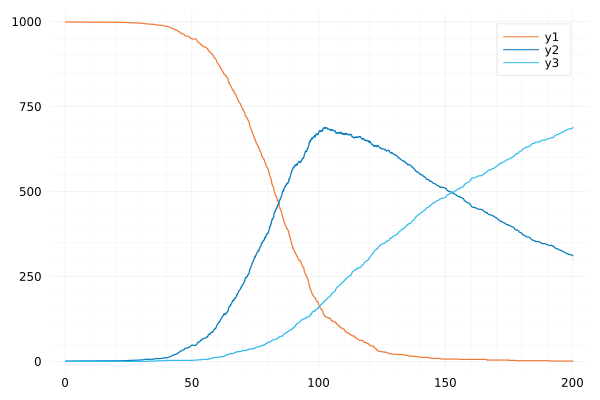

In [147]:
ssaplot(sol)